In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
# from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
# IMPORT XGBOOST
from xgboost import XGBClassifier
import warnings
import pickle
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import scipy.sparse as sp

In [3]:
from sklearnex import patch_sklearn
from cuml.svm import SVC
import cupy
from cuml.manifold import TSNE

In [4]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
metrics={'times':{},'accuracies':{},'macro_f1s':{},'macro_f1s_train':{},'accuracies_train':{}}

In [6]:
def model_classifier(X_train,X_test,y_train,y_test,model,model_name):
    mod = model
    params = mod.get_params()
    print(params)
        
    print(mod)
    print(f"{model_name} training")
    start_time = time.time()
    mod.fit(X_train, y_train)
    end_time = time.time()
    y_pred = mod.predict(X_test)
    y_pred_train = mod.predict(X_train)
    
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    accuracy_train = accuracy_score(y_train, y_pred_train)
    macro_f1_train = f1_score(y_train, y_pred_train, average='macro')

    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    metrics['times'][model_name] = (end_time-start_time)
    metrics['accuracies'][model_name] = accuracy
    metrics['macro_f1s'][model_name] = macro_f1
    metrics['accuracies_train'][model_name] = accuracy_train
    metrics['macro_f1s_train'][model_name] = macro_f1_train
    
    print("Accuracy:", accuracy)
    print("Macro f1:",macro_f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)
    return mod

### Reading the dataset and performing the train test split ###

In [7]:
data = pd.read_csv('/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv')
print(data.shape)
data.columns

(354862, 40)


Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [8]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['State',
 'Sex',
 'GeneralHealth',
 'LastCheckupTime',
 'PhysicalActivities',
 'RemovedTeeth',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'SmokerStatus',
 'ECigaretteUsage',
 'ChestScan',
 'RaceEthnicityCategory',
 'AgeCategory',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos']

In [9]:
numerical_columns = data.select_dtypes(include=['number']).columns
numerical_columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')

In [10]:
# Perform train test split
# y = data['GeneralHealth']
# X = data.drop('GeneralHealth', axis=1)
standard_scaler = StandardScaler()  
label_encoder = LabelEncoder()


for i in categorical_features:
    data[i] = label_encoder.fit_transform(data[i])

X_train,X_test = train_test_split(data,test_size=0.2, random_state=42)
X_train.shape, X_test.shape


X_train[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

Y_test = X_test.pop('GeneralHealth')
Y_train = X_train.pop('GeneralHealth')

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


((283889, 39), (70973, 39), (283889,), (70973,))

## TSNE

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [06:33:43.427364] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
<class 'numpy.ndarray'>


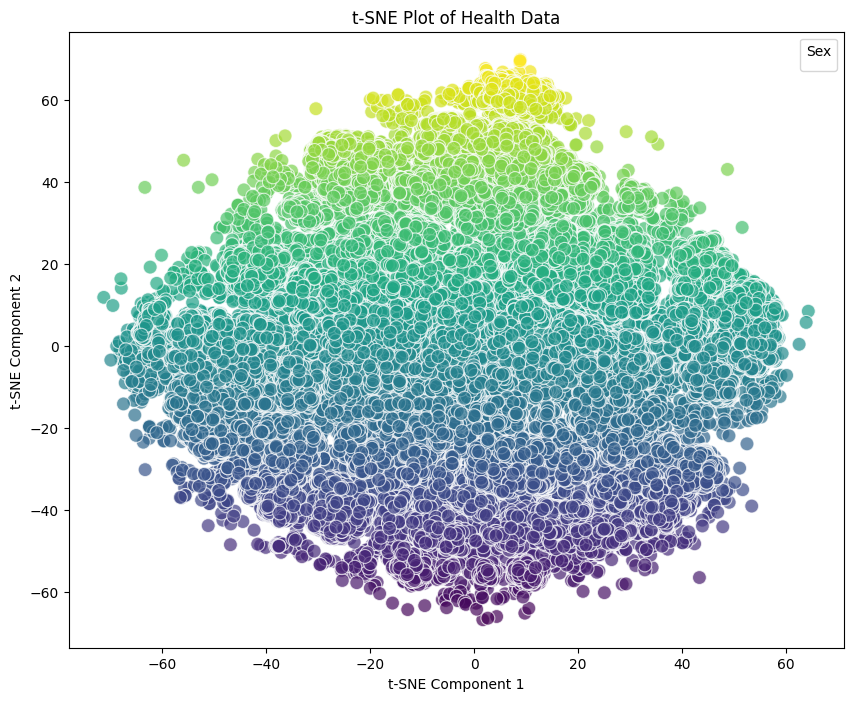

In [11]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_train).to_numpy()
print(type(tsne_results))
df=pd.DataFrame()
df['TSNE1'] = tsne_results[:, 0]
df['TSNE2'] = tsne_results[:, 1]
y=tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', data=df, c=y, s=100, alpha=0.7)
plt.title('t-SNE Plot of Health Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Sex')
plt.show()


## PCA

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


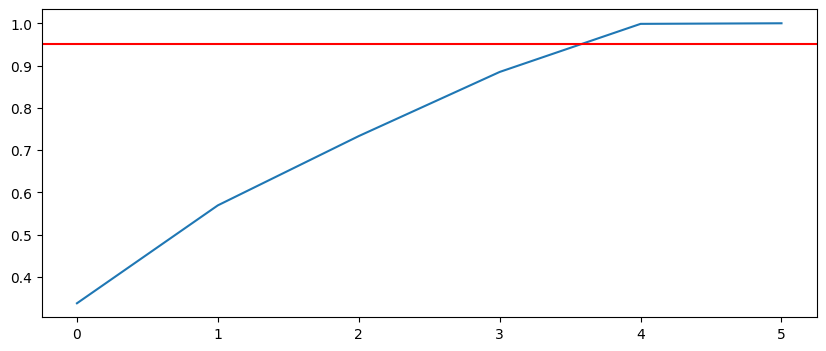

In [12]:
categorical_columns=categorical_features.copy()
categorical_columns.pop(categorical_columns.index('GeneralHealth'))


pca = PCA()
x_pca_2 = pca.fit(X_train[numerical_columns])
values = pca.explained_variance_ratio_

plt.figure(figsize = (10, 4))
ax = plt.subplot(111)

cumulative = np.cumsum(values)
ax.plot(cumulative)
plt.axhline(y=0.95, color='r', linestyle='-')
#print intersection point oh the red line with the curve

pca=PCA(n_components=4)
x_pca = pca.fit_transform(X_train[numerical_columns])

In [13]:
# x_pca=pca.transform(X_train[numerical_columns])
# x_pca = pd.DataFrame(x_pca)
# x_pca = pd.concat([x_pca,X_train[categorical_columns]],axis=1)
# X_train=x_pca.to_numpy()

# x_pca=pca.transform(X_test[numerical_columns])
# x_pca = pd.DataFrame(x_pca)
# x_pca = pd.concat([x_pca,X_test[categorical_columns]],axis=1)
# X_test=x_pca.to_numpy()
# X_train.shape, X_test.shape

## JL

In [14]:
def create_matrix_feature(d,n):
    matrix = np.random.normal(loc=0, scale=1.0/np.sqrt(n), size=(d, n))
    return matrix
output_dim=20
matrix_1=create_matrix_feature(X_train.shape[1],20)

In [15]:
# X_train=X_train.dot(matrix_1)
# X_test=X_test.dot(matrix_1)

## Undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state= 42)
X_train , Y_train = rus.fit_resample(X_train, Y_train)
X_train.shape,Y_train.shape

((61300, 39), (61300,))

### Naive Bayes ###

**Default**

In [17]:
model_naive  = model_classifier(X_train,X_test,Y_train,Y_test,GaussianNB(),"Naive_Bayes")
pickle.dump(model_naive, open('naive_bayes_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'priors': None, 'var_smoothing': 1e-09}
GaussianNB()
Naive_Bayes training
Accuracy: 0.30742676792583096
Macro f1: 0.31835773463986966
Confusion Matrix:
 [[ 9369   401   882    80   659]
 [ 1283  2984  1844  2675   786]
 [ 9728  3857  4650  1330  2990]
 [   70   667   198  2185    48]
 [16439  1762  3096   359  2631]]
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.82      0.39     11391
           1       0.31      0.31      0.31      9572
           2       0.44      0.21      0.28     22555
           3       0.33      0.69      0.45      3168
           4       0.37      0.11      0.17     24287

    accuracy                           0.31     70973
   macro avg       0.34      0.43      0.32     70973
weighted avg       0.36      0.31      0.27     70973



### Logistic Regression ###

**Default**

In [18]:
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,LogisticRegression(verbose=True),"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': True, 'warm_start': False}
LogisticRegression(verbose=True)
Logistic_Regression training
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86585D+04    |proj g|=  2.11217D+04


 This problem is unconstrained.



At iterate   50    f=  7.33283D+04    |proj g|=  4.43549D+03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



At iterate  100    f=  7.20577D+04    |proj g|=  4.83328D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  200    100    111      1     0     0   4.833D+03   7.206D+04
  F =   72057.714191575491     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Accuracy: 0.3817930762402604
Macro f1: 0.3957528636198626
Confusion Matrix:
 [[ 7493   320  1121   106  2351]
 [  753  3492  1894  2708   725]
 [ 5667  4170  6390  1162  5166]
 [   45   499   136  2444    44]
 [10573  1513  4548   375  7278]]
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.66      

In [19]:
lr_model = LogisticRegression(random_state=42)

lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1],           
    'solver': ['liblinear', 'saga'] 
}

lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=-1)
print("-" * 20, "METRICS ON DATASET (Logistic Regression)", "-" * 20)
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,lr_grid,"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Logistic Regression) --------------------
{'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 42, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(random_state=42), 'n_jobs': -1, 'param_grid': {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1], 'solver': ['liblinear', 'saga']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1], 'penalty': ['l2'],
                         'solver': [

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
INFO:sklearne

Accuracy: 0.39140236427937386
Macro f1: 0.40499328035139337
Confusion Matrix:
 [[ 7537   290  1247   115  2202]
 [  648  3446  2217  2632   629]
 [ 5351  3871  7303  1110  4920]
 [   39   500   138  2455    36]
 [10654  1353  4878   364  7038]]
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.66      0.42     11391
           1       0.36      0.36      0.36      9572
           2       0.46      0.32      0.38     22555
           3       0.37      0.77      0.50      3168
           4       0.47      0.29      0.36     24287

    accuracy                           0.39     70973
   macro avg       0.40      0.48      0.40     70973
weighted avg       0.42      0.39      0.38     70973



### Random Forest ###

**Default**

In [20]:
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,RandomForestClassifier(verbose=True,n_jobs=-1),"Random_Forest")
pickle.dump(model_rf, open('model_rf_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': True, 'warm_start': False}
RandomForestClassifier(n_jobs=-1, verbose=True)
Random_Forest training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

Accuracy: 0.3866258999901371
Macro f1: 0.3995090267661513
Confusion Matrix:
 [[6722  445 1466  107 2651]
 [ 489 3809 1933 2709  632]
 [4399 5013 7099 1172 4872]
 [  25  572  125 2410   36]
 [8914 2047 5526  400 7400]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.59      0.42     11391
           1       0.32      0.40      0.36      9572
           2       0.44      0.31      0.37     22555
           3       0.35      0.76      0.48      3168
           4       0.47      0.30      0.37     24287

    accuracy                           0.39     70973
   macro avg       0.38      0.47      0.40     70973
weighted avg       0.41      0.39      0.38     70973



In [21]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100],       
    'max_depth': [None, 10],         
    'min_samples_split': [2, 5],     
    'min_samples_leaf': [1, 2]       
}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (Random Forest)", "-" * 20)
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,rf_grid,"Random_Forest")
pickle.dump(model_rf, open('model_rf_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Random Forest) --------------------
{'cv': 3, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
Grid

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation.

Accuracy: 0.3953052569286912
Macro f1: 0.40692440622231374
Confusion Matrix:
 [[6845  410 1424  100 2612]
 [ 482 3863 1874 2712  641]
 [4377 4862 7217 1188 4911]
 [  22  560  126 2420   40]
 [8830 1937 5400  409 7711]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.60      0.43     11391
           1       0.33      0.40      0.36      9572
           2       0.45      0.32      0.37     22555
           3       0.35      0.76      0.48      3168
           4       0.48      0.32      0.38     24287

    accuracy                           0.40     70973
   macro avg       0.39      0.48      0.41     70973
weighted avg       0.42      0.40      0.39     70973



### Decision Tree ###

**Default**

In [22]:
model_dt = model_classifier(X_train,X_test,Y_train,Y_test,DecisionTreeClassifier(),"Decision_Tree")
pickle.dump(model_dt, open('model_dt_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
DecisionTreeClassifier()
Decision_Tree training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.3217984303890212
Macro f1: 0.3201500971343867
Confusion Matrix:
 [[4561  905 2283  241 3401]
 [ 759 3020 2048 2525 1220]
 [4433 4638 6081 1886 5517]
 [  67  869  303 1789  140]
 [7231 2943 5868  857 7388]]
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.40      0.32     11391
           1       0.24      0.32      0.28      9572
           2       0.37      0.27      0.31     22555
           3       0.25      0.56      0.34      3168
           4       0.42      0.30      0.35     24287

    accuracy                           0.32     70973
   macro avg       0.31      0.37      0.32     70973
weighted avg       0.35      0.32      0.32     70973



In [23]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'criterion': ['gini', 'entropy'],     
    'max_depth': [5, 10],              
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2]            
}

dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-"*20,"METRICS ON DATASET", "-"*20)
model_dt_grid = model_classifier(X_train,X_test,Y_train,Y_test,dt_grid,"Decision_Tree")
pickle.dump(model_dt_grid, open('model_dt_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET --------------------
{'cv': 3, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'min_sampl

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.3575303284347569
Macro f1: 0.3665579963101033
Confusion Matrix:
 [[ 7554   452  1480   139  1766]
 [  841  3217  2220  2764   530]
 [ 6235  4199  7537  1361  3223]
 [   51   584   196  2309    28]
 [11338  1920  5805   466  4758]]
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.66      0.40     11391
           1       0.31      0.34      0.32      9572
           2       0.44      0.33      0.38     22555
           3       0.33      0.73      0.45      3168
           4       0.46      0.20      0.28     24287

    accuracy                           0.36     70973
   macro avg       0.37      0.45      0.37     70973
weighted avg       0.40      0.36      0.34     70973



### SVM ###

**Default**

In [24]:
model_svm = model_classifier(X_train,X_test,Y_train,Y_test,SVC(verbose=True),"SVM")
pickle.dump(model_svm, open('model_svm_default.pkl', 'wb'))

{'handle': <pylibraft.common.handle.Handle object at 0x7eba657a5f20>, 'verbose': 5, 'output_type': 'input', 'C': 1, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'coef0': 0.0, 'tol': 0.001, 'cache_size': 1024.0, 'max_iter': -1, 'nochange_steps': 1000, 'probability': False, 'random_state': None, 'class_weight': None, 'multiclass_strategy': 'ovo'}
SVC()
SVM training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


[D] [06:36:22.914850] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [06:36:23.524226] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 35 outer iterations, total inner 8742 iterations, and diff 0.000878
[D] [06:36:23.639325] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [06:36:24.337572] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 59 outer iterations, total inner 14038 iterations, and diff 0.000984
[D] [06:36:24.357424] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [06:36:24.567680] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 19 outer iterations, total inner 4412 iterations, and diff 0.000992
[D] [06:36:24.589588] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [06:36:25.4

### Ada Boost ###


**Default**

In [25]:
model_ada = model_classifier(X_train,X_test,Y_train,Y_test,AdaBoostClassifier(),"ADA_Boost")
pickle.dump(model_ada, open('model_ada_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._a

{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
AdaBoostClassifier()
ADA_Boost training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._

Accuracy: 0.4022092908570865
Macro f1: 0.40897772239311453
Confusion Matrix:
 [[6213  301 1289  114 3474]
 [ 662 3437 2058 2807  608]
 [4733 4032 7384 1199 5207]
 [  45  516  127 2452   28]
 [8230 1390 5199  408 9060]]
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.55      0.40     11391
           1       0.36      0.36      0.36      9572
           2       0.46      0.33      0.38     22555
           3       0.35      0.77      0.48      3168
           4       0.49      0.37      0.42     24287

    accuracy                           0.40     70973
   macro avg       0.39      0.48      0.41     70973
weighted avg       0.43      0.40      0.40     70973



In [26]:
ab_model = AdaBoostClassifier(random_state=42)

ab_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1, 1] 
}

ab_grid = GridSearchCV(ab_model, ab_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (AdaBoost)", "-" * 20)
model_ada_grid = model_classifier(X_train,X_test,Y_train,Y_test,ab_grid,"ADA_Boost")
pickle.dump(model_ada_grid, open('model_ada_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (AdaBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__algorithm': 'SAMME.R', 'estimator__base_estimator': 'deprecated', 'estimator__estimator': None, 'estimator__learning_rate': 1.0, 'estimator__n_estimators': 50, 'estimator__random_state': 42, 'estimator': AdaBoostClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100]},
             scoring='f1_macro', verbose=4)
ADA_Boost training
Fitting 3 folds for each of 6 candidates, totalling 18 fits


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._a

Accuracy: 0.40583038620320405
Macro f1: 0.4137351675374852
Confusion Matrix:
 [[6433  319 1226  110 3303]
 [ 712 3593 2082 2615  570]
 [4867 4062 7360 1117 5149]
 [  45  590  132 2374   27]
 [8215 1379 5269  381 9043]]
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.56      0.41     11391
           1       0.36      0.38      0.37      9572
           2       0.46      0.33      0.38     22555
           3       0.36      0.75      0.49      3168
           4       0.50      0.37      0.43     24287

    accuracy                           0.41     70973
   macro avg       0.40      0.48      0.41     70973
weighted avg       0.43      0.41      0.40     70973



### XG Boost ###

**Default**

In [27]:
model_xg = model_classifier(cupy.array(X_train),cupy.array(X_test),Y_train,Y_test,XGBClassifier(device='cuda'),"XG_Boost")
pickle.dump(model_xg, open('model_xg_default.pkl', 'wb'))

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None,

In [28]:
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],      
    'subsample': [0.8, 1.0]    
}

# Setup GridSearchCV
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)

# Train and save the model
print("-" * 20, "METRICS ON DATASET (XGBoost)", "-" * 20)
model_xgb_grid = model_classifier(cupy.array(X_train), cupy.array(X_test), Y_train, Y_test, xgb_grid, "XG_Boost")
pickle.dump(model_xgb_grid, open('model_xgb_grid.pkl', 'wb'))


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (XGBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__objective': 'binary:logistic', 'estimator__base_score': None, 'estimator__booster': None, 'estimator__callbacks': None, 'estimator__colsample_bylevel': None, 'estimator__colsample_bynode': None, 'estimator__colsample_bytree': None, 'estimator__device': None, 'estimator__early_stopping_rounds': None, 'estimator__enable_categorical': False, 'estimator__eval_metric': None, 'estimator__feature_types': None, 'estimator__gamma': None, 'estimator__grow_policy': None, 'estimator__importance_type': None, 'estimator__interaction_constraints': None, 'estimator__learning_rate': None, 'estimator__max_bin': None, 'estimator__max_cat_threshold': None, 'estimator__max_cat_to_onehot': None, 'estimator__max_delta_step': None, 'estimator__max_depth': None, 'estimator__max_leaves': None, 'estimator__min_child_weight': None, 'estimator__missing': nan, 'estimator__monotone_constraints': None, 'es

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:37:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:37:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Accuracy: 0.3968974116917701
Macro f1: 0.4112023325438555
Confusion Matrix:
 [[7439  402 1153  117 2280]
 [ 549 4099 1782 2538  604]
 [4898 4914 6703 1079 4961]
 [  29  592  112 2402   33]
 [9858 1836 4687  380 7526]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.65      0.44     11391
           1       0.35      0.43      0.38      9572
           2       0.46      0.30      0.36     22555
           3       0.37      0.76      0.50      3168
           4       0.49      0.31      0.38     24287

    accuracy                           0.40     70973
   macro avg       0.40      0.49      0.41     70973
weighted avg       0.43      0.40      0.39     70973



In [29]:
df = pd.DataFrame(metrics)
df.to_csv("Metrics.csv")
df

,times,accuracies,macro_f1s,macro_f1s_train,accuracies_train
Naive_Bayes,0.041223,0.307427,0.318358,0.389804,0.427651
Logistic_Regression,34.839495,0.391402,0.404993,0.469231,0.481142
Random_Forest,77.163552,0.395305,0.406924,0.965761,0.965644
Decision_Tree,5.967576,0.357530,0.366558,0.480042,0.495954
SVM,8.369846,0.384780,0.392128,0.457606,0.473034
ADA_Boost,27.248340,0.405830,0.413735,0.473821,0.479299
XG_Boost,68.683289,0.396897,0.411202,0.512734,0.522447


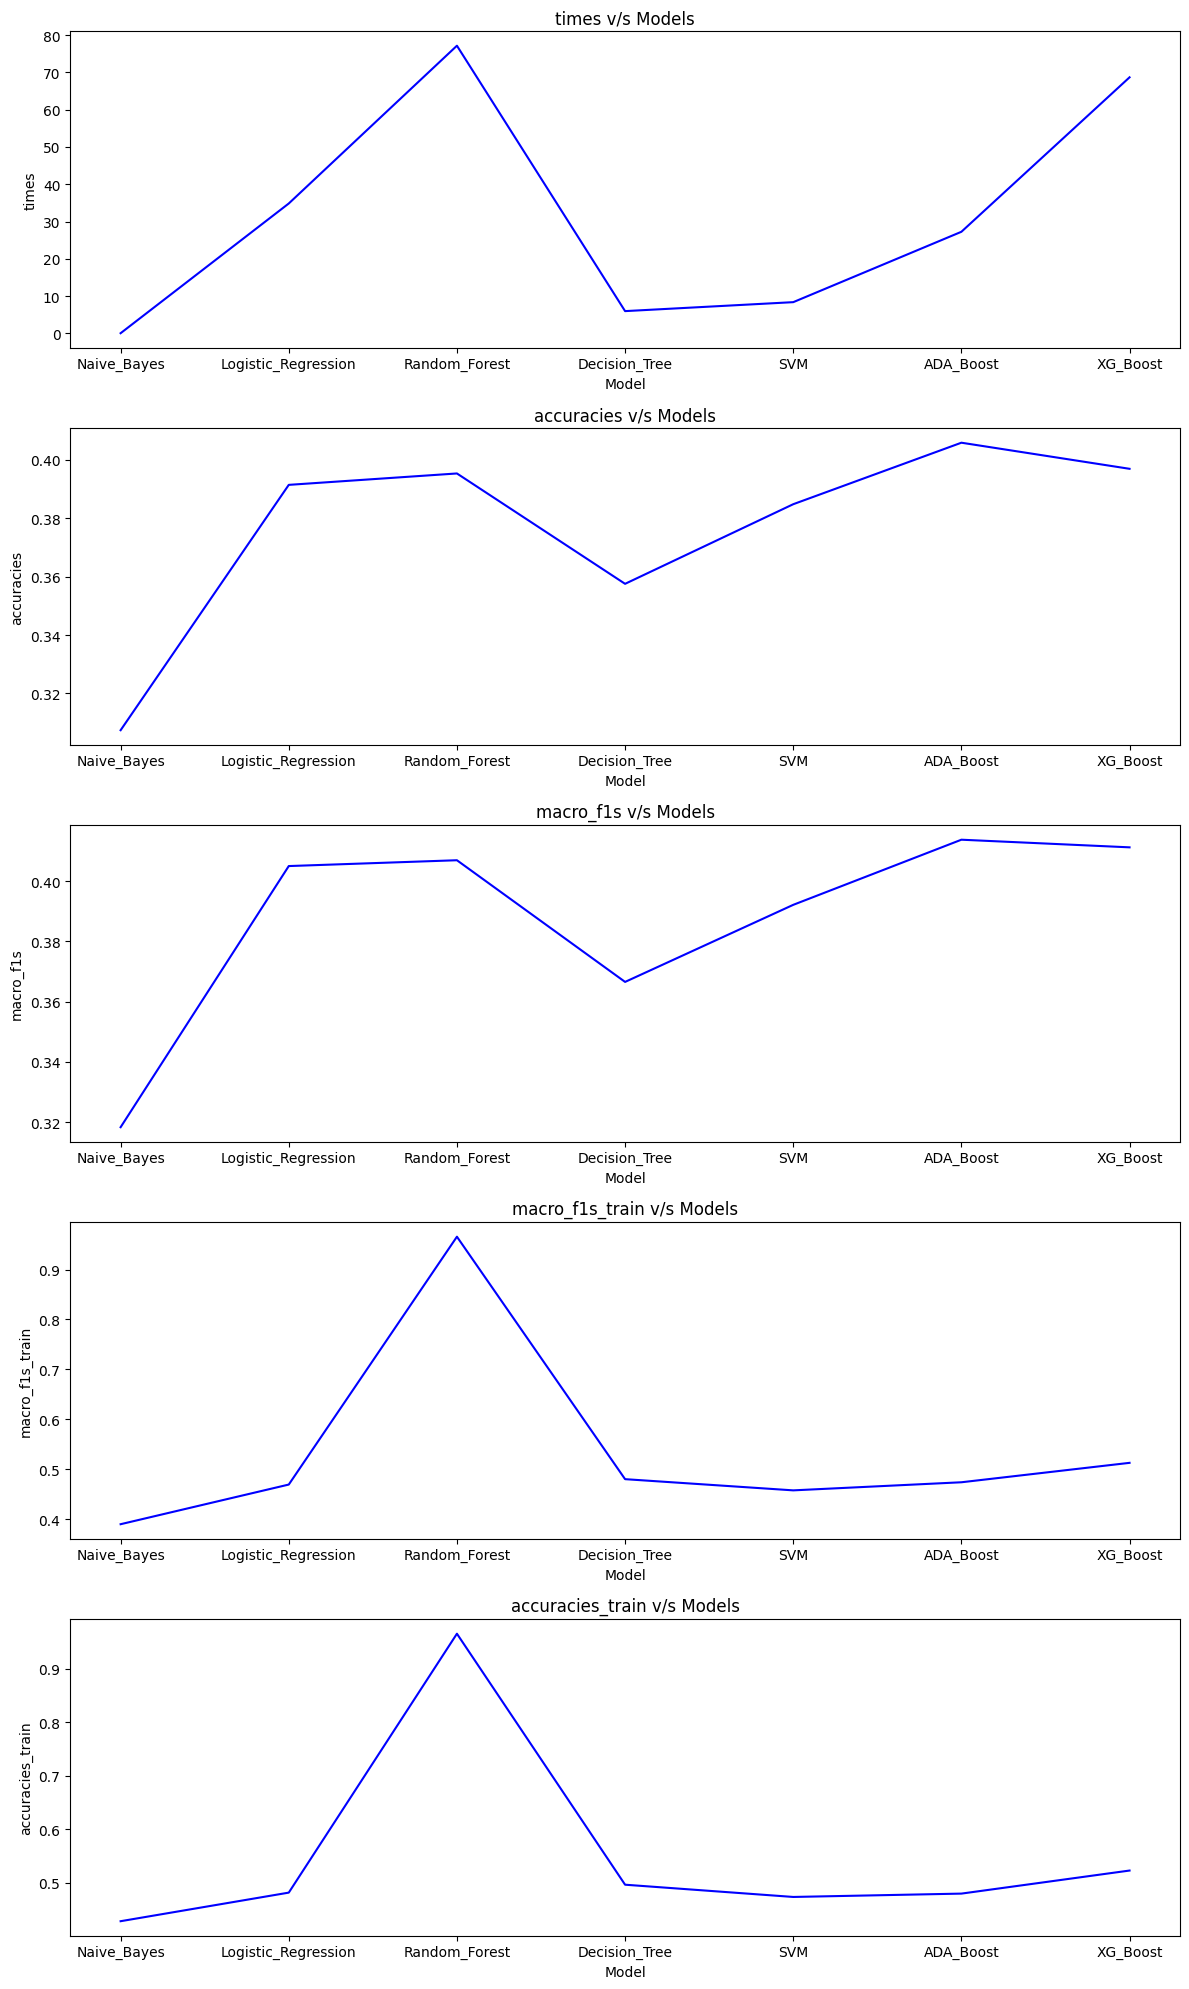

In [30]:
models = [df.index[i] for i in range(df.shape[0])]
metrics = [df.columns[i] for i in range(df.shape[1])]

fig,axes = plt.subplots(5,figsize=(12,20))

for i in range(len(metrics)):
    # print(i)
    # print(row)
    row = df.iloc[:,i]
    axes[i].set_title(f"{metrics[i]} v/s Models")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(f"{metrics[i]}")
    axes[i].plot(models,row,color='blue')
    
plt.tight_layout()
plt.savefig("Metrics.png")
plt.show()